In [1]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plot_loss
from torch import optim
from tqdm.notebook import trange

from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer

from tensorboardX import SummaryWriter

from torch.nn.functional import normalize
from sklearn.preprocessing import StandardScaler

from memflow.unfolding_flow.utils import *
torch.cuda.empty_cache()

In [2]:
from omegaconf import OmegaConf

config = {
    "name": "cond_pretraining_particles",
    "version": "v2",
    
    "description": "",
    "input_dataset": "../../../dataset/v7",
    "input_shape": {
        "number_jets": 15,
        "jets_features": 5,
        "number_lept": 1,
        "lepton_features": 3
    },
    "conditioning_transformer":{
        "out_features": 4, # the 4 momenta
        "hidden_features": 32,
        "dim_feedforward_transformer": 512,
        "nhead_encoder": 2,
        "no_layers_encoder": 3,
        "nhead_decoder": 1,
        "no_layers_decoder": 1,
        "aggregate": False,
        "no_decoders": 3,
        
    },    
    "training_params":
    {
        "lr": 1e-4,
        "batch_size": 1024,
        "batch_size_training": 1024,
        "batch_size_validation": 1024,
        "nepochs": 10,
        "traning_sample": 500000,
        "validation_sample": 69993
    }
}

conf = OmegaConf.create(config)

with open(f"runs/config_{conf.name}_{conf.version}.yaml", "w") as fo:
    fo.write(OmegaConf.to_yaml(conf))

In [3]:
batch_size = conf.training_params.batch_size
device = torch.device('cuda')

data_cuda = DatasetCombined(conf.input_dataset, debug=True, dev=device, dtype=torch.float64)


train_subset, val_subset = torch.utils.data.random_split(
        data_cuda, [conf.training_params.traning_sample, conf.training_params.validation_sample],
        generator=torch.Generator().manual_seed(1))

# just reload it, don't call again DatasetCombined
#dataiterator = DataLoader(dataset=data_cuda, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=conf.training_params.batch_size_training)
val_loader = DataLoader(dataset=val_subset, shuffle=True, batch_size=conf.training_params.batch_size_validation)

File missing: compute boost
jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
Create new file for recoParticles_Cartesian
Create new file for recoParticlesScaled
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists


In [42]:
import torch.nn as nn
from torch.nn.functional import gelu
from torch.nn import ModuleList

class PreTrainer(nn.Module):
    
    def __init__(self, conf, dtype=torch.float32):
        super().__init__()
        
        self.cond_transformer = ConditioningTransformerLayer(
                                            no_jets = conf.input_shape.number_jets,
                                            jets_features=conf.input_shape.jets_features, 
                                            no_lept = conf.input_shape.number_lept,
                                            lepton_features=conf.input_shape.lepton_features, 
                                            hidden_features=conf.conditioning_transformer.hidden_features,
                                            out_features=conf.conditioning_transformer.out_features,
                                            nhead=conf.conditioning_transformer.nhead,
                                            no_layers=conf.conditioning_transformer.no_layers,
                                            dtype=torch.float64) 
        
        hidden_dim = conf.pretrainer_regression.hidden_layers 
        hidden_dim.append(4) # the output
        
        self.H_out = ModuleList([nn.Linear(in_features=conf.conditioning_transformer.out_features,
                              out_features=hidden_dim[0], dtype=dtype)])
        
        self.Thad_out =  ModuleList([nn.Linear(in_features=conf.conditioning_transformer.out_features,
                              out_features=hidden_dim[0], dtype=dtype)])
        
        self.Tlep_out =  ModuleList([nn.Linear(in_features=conf.conditioning_transformer.out_features,
                              out_features=hidden_dim[0], dtype=dtype)])
        
        
        for i in range(len(hidden_dim)-1):
            self.H_out.append(nn.Linear(in_features=hidden_dim[i],
                                       out_features=hidden_dim[i+1], dtype=dtype))
            self.Thad_out.append(nn.Linear(in_features=hidden_dim[i],
                                       out_features=hidden_dim[i+1], dtype=dtype))
            self.Tlep_out.append(nn.Linear(in_features=hidden_dim[i],
                                       out_features=hidden_dim[i+1], dtype=dtype))
        
    
    def forward(self, x):
        (mask_partons, data_partons, 
            mask_lepton_partons, data_lepton_partons,
            mask_boost, data_boost, 
            data_httg, data_httg_cartesian, 
            ps, ps_detjac, 
            mask_lepton_reco, data_lepton_reco, 
            mask_jets, data_jets, 
            mask_met, data_met, 
            mask_boost_reco, data_boost_reco) = x
        
        out_cond = self.cond_transformer(data_jets,
                    data_lepton_reco,
                    data_met,
                    data_boost_reco, 
                    mask_jets, 
                    mask_lepton_reco, 
                    mask_met, 
                    mask_boost_reco)

        hout = out_cond
        for mod in self.H_out[:-1]:
            hout = gelu(mod(hout))
        hout = self.H_out[-1](hout)
        
        tlepout = out_cond
        for mod in self.Tlep_out[:-1]:
            tlepout = gelu(mod(tlepout))
        tlepout = self.Tlep_out[-1](tlepout)
        
        thadout = out_cond 
        for mod in self.Thad_out[:-1]:
            thadout = gelu(mod(thadout))
        thadout = self.Thad_out[-1](thadout)
        
        return out_cond, hout, tlepout, thadout

In [43]:
(mask_partons, data_partons, 
            mask_lepton_partons, data_lepton_partons,
            mask_boost, data_boost, 
 
            data_httg, data_httg_cartesian, 
            ps, ps_detjac, 
            mask_lepton_reco, data_lepton_reco, 
            mask_jets, data_jets, 
            mask_met, data_met, 
            mask_boost_reco, data_boost_reco,
recoParticles, recoParticlesScaled) = next(iter(train_loader))

In [44]:
model = ConditioningTransformerLayer(no_jets = conf.input_shape.number_jets,
                                    jets_features=conf.input_shape.jets_features, 
                                    no_lept = conf.input_shape.number_lept,
                                    lepton_features=conf.input_shape.lepton_features, 
                                    hidden_features=conf.conditioning_transformer.hidden_features,
                                    dim_feedforward_transformer= conf.conditioning_transformer.dim_feedforward_transformer,
                                    out_features=conf.conditioning_transformer.out_features,
                                    nhead_encoder=conf.conditioning_transformer.nhead_encoder,
                                    no_layers_encoder=conf.conditioning_transformer.no_layers_encoder,
                                    nhead_decoder=conf.conditioning_transformer.nhead_decoder,
                                    no_layers_decoder=conf.conditioning_transformer.no_layers_decoder,
                                     no_decoders=conf.conditioning_transformer.no_decoders,
                                     aggregate=conf.conditioning_transformer.aggregate,
                                    dtype=torch.float64).cuda()

In [45]:
out = model(data_jets, data_lepton_reco, data_met, data_boost_reco, mask_jets, mask_lepton_reco, mask_met, mask_boost_reco)

In [46]:
out[0].shape

torch.Size([1024, 4])

In [47]:


nepochs = conf.training_params.nepochs
lr_init = conf.training_params.lr
version = conf.version

name_dir = f'runs/{conf.name}_{conf.version}'
writer = SummaryWriter(name_dir)

loss_fn = torch.nn.MSELoss()
#scaler = torch.cuda.amp.GradScaler()

optimizer = optim.Adam(list(model.parameters()) , lr=lr_init)

# decay = 0.0001
# fcn = lambda step: 1./(1. + decay*step)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

#print(f"parameters flow:{count_parameters(model.flow)}, parameters conditioner: {count_parameters(model.cond_transformer_lambda)}")
print(f"parameters total:{count_parameters(model)}")

parameters total:226969


In [48]:
N_train = len(train_loader)
N_valid = len(val_loader)
print(f"Training steps: {N_train}, Validation steps: {N_valid}")

ii = 0
for e in range(nepochs):
    
    sum_loss = 0.
    
    print("Before training loop")
    for i, data in enumerate(train_loader):
        ii += 1
        if (i % 10 == 0):
            print(i)
      
    
        (mask_partons, data_partons, 
            mask_lepton_partons, data_lepton_partons,
            mask_boost, data_boost, 
            data_httg, data_httg_cartesian, 
            ps, ps_detjac, 
            mask_lepton_reco, data_lepton_reco, 
            mask_jets, data_jets, 
            mask_met, data_met, 
            mask_boost_reco, data_boost_reco,
        recoParticles, recoParticlesScaled) = data 
        
        optimizer.zero_grad()
        
        out = model(data_jets, data_lepton_reco, data_met, 
                    data_boost_reco, mask_jets, mask_lepton_reco, mask_met, mask_boost_reco)
        
        #out_cond, h_out, tlep_out, thad_out = model(data)
        
        target = data[7]
        
        lossH = loss_fn(target[:,0], out[0])
        lossThad =  loss_fn(target[:,1], out[1])
        lossTlep =  loss_fn(target[:,2], out[2])
        writer.add_scalar('loss_H', lossH.item(), ii)
        writer.add_scalar('loss_Thad', lossThad.item(), ii)
        writer.add_scalar('loss_Tlep', lossTlep.item(), ii)
        

        loss = lossH + lossThad + lossTlep
        #print(loss.item())
        
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        loss.backward()
        optimizer.step()
    
        sum_loss += loss.item()
        
        writer.add_scalar("Loss_step_train", loss.item(), ii)
        #steps.set_description(f"Step loss: {loss.item()}")

    writer.add_scalar('Loss_epoch_train', sum_loss/N_train, e)
    #epoch.set_description(sum_loss/N_train)
    valid_loss = 0
    valid_lossH = 0
    valid_lossTlep = 0
    valid_lossThad = 0
    
    # validation loop (don't update weights and gradients)
    print("Before validation loop")
    for i, data in enumerate(val_loader):
        
        with torch.no_grad():
            
            (mask_partons, data_partons, 
            mask_lepton_partons, data_lepton_partons,
            mask_boost, data_boost, 
            data_httg, data_httg_cartesian, 
            ps, ps_detjac, 
            mask_lepton_reco, data_lepton_reco, 
            mask_jets, data_jets, 
            mask_met, data_met, 
            mask_boost_reco, data_boost_reco,
            recoParticles, recoParticlesScaled) = data 
        
        
            out = model(data_jets, data_lepton_reco, data_met, 
                    data_boost_reco, mask_jets, mask_lepton_reco, mask_met, mask_boost_reco)
        

            target = data[7]

            lossH = loss_fn(target[:,0], out[0])
            lossThad =  loss_fn(target[:,1], out[1])
            lossTlep =  loss_fn(target[:,2], out[2])

            loss = lossH + lossThad + lossTlep
            valid_loss += loss.item()
            valid_lossH += lossH.item()
            valid_lossTlep += lossTlep.item()
            valid_lossThad += lossThad.item()
#         
        
    writer.add_scalar('Loss_epoch_val', valid_loss/N_valid, e)
    writer.add_scalar('Loss_epoch_val_H', valid_lossH/N_valid, e)
    writer.add_scalar('Loss_epoch_val_Tlep', valid_lossTlep/N_valid, e)
    writer.add_scalar('Loss_epoch_val_Thad', valid_lossThad/N_valid, e)
        
    
writer.close()

Training steps: 489, Validation steps: 69
Before training loop
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
Before validation loop
Before training loop
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
Before validation loop
Before training loop
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
Before validation loop
Before training loop
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
Before validation loop
Before training loop
0
10
20
30
40
50
60
7

In [49]:
plt.imshow(out_cond.cpu().detach().numpy().T[:, 0:30])
plt.colorbar()

NameError: name 'out_cond' is not defined

In [55]:
target.shape

torch.Size([361, 4, 4])

In [51]:
plt.hist2d(thad_out[:,0].cpu().detach().numpy(), target[:,2,0].detach().cpu().numpy(), bins=100);

NameError: name 'thad_out' is not defined

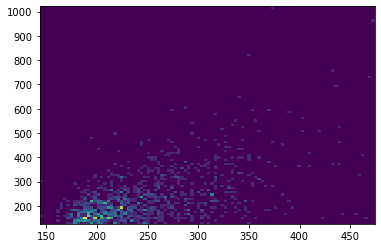

In [48]:
plt.hist2d(h_out[:,0].cpu().detach().numpy(), target[:,0,0].detach().cpu().numpy(), bins=100);

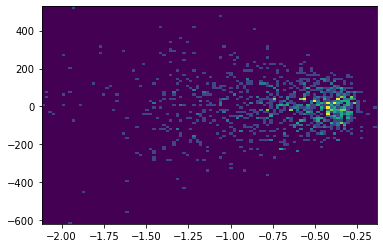

In [49]:
plt.hist2d(h_out[:,1].cpu().detach().numpy(), target[:,0,1].detach().cpu().numpy(), bins=100);

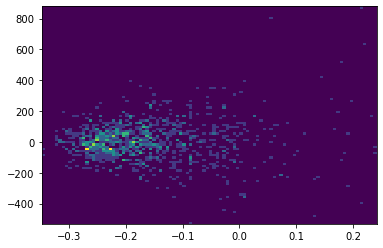

In [50]:
plt.hist2d(h_out[:,2].cpu().detach().numpy(), target[:,0,2].detach().cpu().numpy(), bins=100);

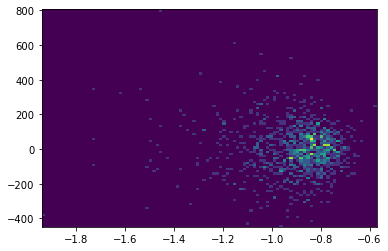

In [51]:
plt.hist2d(h_out[:,3].cpu().detach().numpy(), target[:,0,3].detach().cpu().numpy(), bins=100);

In [52]:
out_cond, h_out, tlep_out, 

NameError: name 'out_cond' is not defined

In [53]:
out.shape

AttributeError: 'list' object has no attribute 'shape'

In [54]:
out_pret = ptrainer(out)

NameError: name 'ptrainer' is not defined

In [81]:
loss = torch.nn.MSELoss()

In [82]:
loss(out_pret[0] , data_httg_cartesian[:,0])

tensor(27682.3068, grad_fn=<MseLossBackward0>)

In [83]:
loss(out_pret[1] , data_httg_cartesian[:,1])

tensor(57334.8288, grad_fn=<MseLossBackward0>)

(array([5.000e+00, 7.000e+00, 1.800e+01, 3.000e+01, 6.300e+01, 1.070e+02,
        1.380e+02, 1.940e+02, 2.290e+02, 2.950e+02, 3.190e+02, 3.780e+02,
        3.180e+02, 3.820e+02, 3.300e+02, 3.270e+02, 3.140e+02, 2.960e+02,
        3.060e+02, 4.400e+02, 5.090e+02, 6.790e+02, 7.180e+02, 7.390e+02,
        7.150e+02, 7.190e+02, 6.610e+02, 6.330e+02, 7.100e+02, 7.090e+02,
        7.090e+02, 7.900e+02, 8.700e+02, 8.340e+02, 9.090e+02, 9.350e+02,
        9.620e+02, 9.520e+02, 9.620e+02, 1.006e+03, 1.055e+03, 1.074e+03,
        1.054e+03, 1.156e+03, 1.207e+03, 1.191e+03, 1.327e+03, 1.316e+03,
        1.322e+03, 2.503e+03, 2.872e+03, 2.159e+03, 1.763e+03, 1.570e+03,
        1.458e+03, 1.362e+03, 1.329e+03, 1.330e+03, 1.251e+03, 1.232e+03,
        1.163e+03, 1.217e+03, 1.269e+03, 1.258e+03, 1.214e+03, 1.256e+03,
        1.185e+03, 1.093e+03, 1.079e+03, 9.820e+02, 9.150e+02, 8.270e+02,
        7.550e+02, 6.280e+02, 5.610e+02, 5.500e+02, 4.620e+02, 4.380e+02,
        3.450e+02, 3.360e+02, 3.300e+0

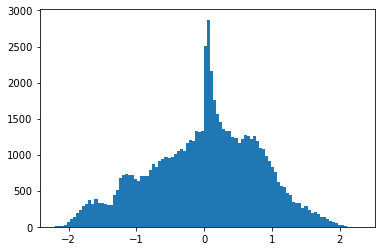

In [40]:
plt.hist(out.detach().flatten().numpy(), bins=100)

# TEST scaled tensor

In [11]:
reco = data_cuda.reco_data.recoParticlesCartesian
mask1 = data_cuda.reco_data.mask_jets
mask2 = data_cuda.reco_data.mask_lepton
mask3 = data_cuda.reco_data.mask_met
recoMask = torch.cat((mask1, mask2, mask3), 1)

recoCPU = reco.detach().cpu()
recoMask = recoMask.detach().cpu()

recoCPU = recoCPU.numpy()
recoMask = recoMask.numpy()
print(recoCPU.shape)
print(recoMask.shape)

print(recoCPU[0,:,1])
print(np.sum(recoCPU[0,:,1])) # sum of px should be 0
print(np.sum(recoCPU[0,:,2])) # sum of py should be 0
print(np.sum(recoCPU[0,:,3])) # sum of pz should be 0

(569993, 17, 4)
(569993, 17)
[-46.32181931  49.09199905   2.31276512  25.29977226  24.92102814
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 -43.54915619 -11.75458813]
9.5367431640625e-07
1.9073486328125e-06
-3.814697265625e-06


In [12]:
recoScaled = data_cuda.reco_data.recoParticlesScaled.detach().cpu()
recoScaled = recoScaled.numpy()

print(recoScaled.shape)

(569993, 17, 4)


In [15]:
scaler = StandardScaler()

for i in range(4):
    
    # version 1: get scaled tensor using masked numpy
    # (same function is used inside Dataset_Reco_Level: processCartesianScaled)
    feature = recoCPU[:,:,i]
    print(feature.shape)
    print(recoMask.shape)
    feature_manp.ma.masked_array(recoCPU, mask=np.logical_not(recoMask))
    feature_maskedScaled = (feature_masked - feature_masked.mean())/feature_masked.std()
    print(f"MEAN: notScaled: {feature.mean()} vs Scaled: {feature_masked.mean()}")
    print(f"STD: notScaled: {feature.std()} vs Scaled: {feature_masked.std()}")
    
    # version 2: compute scaled tensor using scipy.StandardScaler
    feature_norm = scaler.fit_transform(np.expand_dims(feature_masked.compressed(), 1))

    # version 3: get scaled tensor from dataset
    reco_f = recoScaled[:,:,i]
    reco_masked = np.ma.masked_array(reco_f, mask=np.logical_not(recoMask))

    plt.hist(feature_norm, bins = 100, range=(-5,5), label='x')
    plt.hist(feature_maskedScaled.compressed(), bins=100, label='y')
    plt.hist(reco_masked.compressed(), bins=100, label='z')
    
    plt.title(f"Hist feature {i}")
    plt.legend(loc='upper right')
    plt.show()

(569993, 17)
(569993, 17)


MaskError: Mask and data not compatible: data size is 38759524, mask size is 9689881.